Рассмотрим построение модели регрессии несколькими способами и сравним результаты с библиотечной реализацией

## Генерация данных

Сгенерируем набор данных по закону
$$
y = 1 + 2x + \varepsilon, \quad \varepsilon \sim \mathsf N_{0, 2}, \quad x \in \mathsf U_{1, 10}.
$$

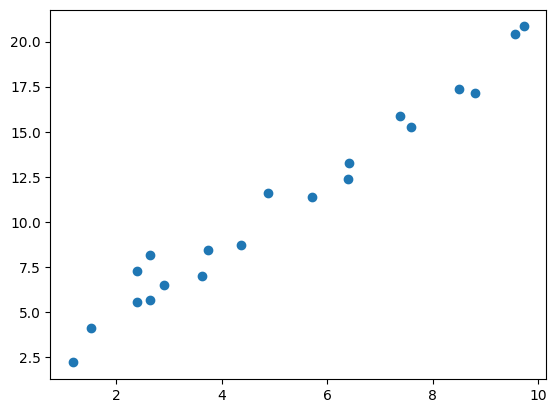

In [8]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = 20
np.random.seed(42)

X = np.random.uniform(1, 10, (n_samples, 1))
Y = (2 * X + 1 + np.random.normal(0, 1, (n_samples, 1))).reshape(-1)

plt.scatter(X, Y)

Будем искать модель, аппроксимирующую наши данные, в виде
$$
y = \theta_0 + \theta_1x,
$$
где $\theta_0$ и $\theta_1$ — параметры, которые нам необходимо определить, основываясь на имеющихся данных.

# Задача 1: Библиотечная реализация

Используя модель `LinearRegression` [из библиотеки sklearn](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html), определите значения параметров $\theta_0$ и $\theta_1$.

In [9]:
from sklearn.linear_model import LinearRegression

def lib_regression(X,Y):
  """Библиотечная реализация линейной регрессии

  Параметры
  ----------
  X : {array-like} формы (n_samples, n_features)
      Тренировочный набор данных, где `n_samples` — число объектов
      и `n_features` — число признаков.
  Y : {array-like} формы (n_samples, 1)
      Отклики для тренировочного набора данных

  Что возвращается
  -------
  (theta_0, theta) : кортеж параметров модели, theta_0 -- параметр (число), отвечающий за сдвиг
  theta -- список из остальных параметров модели
  """
  model = LinearRegression()
  model.fit(X, Y)
  return model.intercept_, model.coef_.tolist()


theta_0, theta = lib_regression(X,Y)

assert np.round(theta_0,5) == 1.021 and np.round(theta[0],5)==1.94261

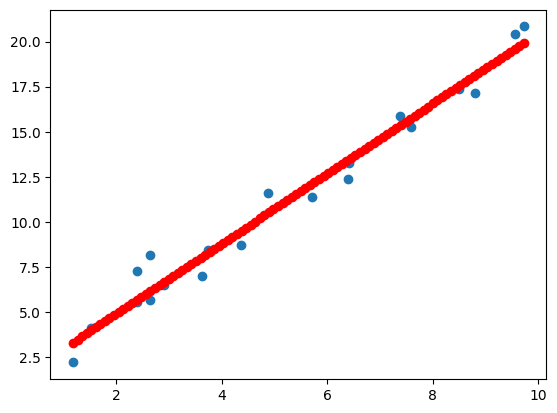

In [10]:
# @title Визуализация результата
plt.scatter(X, Y)
x = np.linspace(np.min(X), np.max(X), 100).reshape(1, -1)
y = x*theta[0] + theta_0
plt.scatter(x, y, color = 'red')

# Задача 2: Аналитическое решение

Используя аналитическое решение, полученное на лекции, определите значения параметров $\theta_0$ и $\theta_1$.

Напоминание: аналитическое решение, полученное на лекции:
$$
\Theta = (X^TX)^{-1}X^TY,
$$
где к матрице $X$ присоединен слева столбец из фиктивных единиц.

**Замечание:** для обращения матрицы рекомендуем использовать [библиотеку numpy](https://numpy.org/devdocs/reference/generated/numpy.linalg.inv.html).

In [11]:
from numpy.linalg import inv

def matrix_regression(X,Y):
  """Реализация линейной регрессии
     аналитическим способом

  Параметры
  ----------
  X : {array-like} формы (n_samples, n_features)
      Тренировочный набор данных, где `n_samples` — число объектов
      и `n_features` — число признаков.
  Y : {array-like} формы (n_samples, 1)
      Отклики для тренировочного набора данных

  Что возвращается
  -------
  (theta_0, theta) : кортеж параметров модели, theta_0 -- параметр (число), отвечающий за сдвиг
  theta -- список из остальных параметров модели
  """
  X_with_ones = np.hstack([np.ones((X.shape[0], 1)), X])
  Y = Y.reshape(-1, 1)
  Theta = inv(X_with_ones.T @ X_with_ones) @ X_with_ones.T @ Y
  return Theta[0, 0], Theta[1:, 0]

theta_0, theta = matrix_regression(X,Y)
assert np.round(theta_0,5) == 1.021 and np.round(theta[0],5)==1.94261

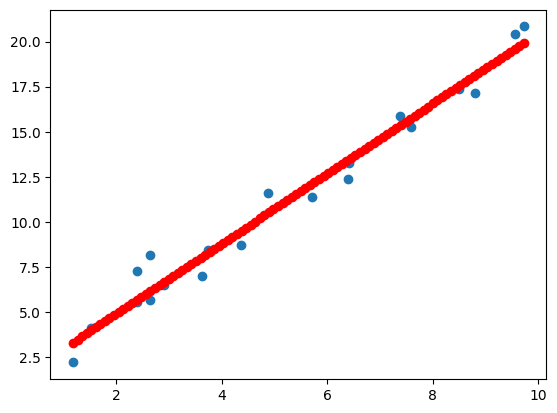

In [12]:
# @title Визуализация результата
plt.scatter(X, Y)
x = np.linspace(np.min(X), np.max(X), 100).reshape(1, -1)
y = x*theta[0] + theta_0
plt.scatter(x, y, color = 'red')

#Задача 3: Градиентный спуск

In [13]:
# Подготовка данных (инициализация)

def initialization(X, random_state=42):
  """
  Инициализация параметров модели и предобработка данных.
  Добавляет столбец единиц к матрице признаков для учета свободного члена (bias).
  Веса инициализируются с помощью np.random.uniform

  Параметры
  ----------
  X : {array-like} формы (n_samples, n_features)
      Тренировочный набор данных.
  random_state : int, default=42
      Зерно для генератора случайных чисел (для воспроизводимости).

  Что возвращается
  -------
  (X, W) : кортеж
      X_new : array-like формы (n_samples, n_features + 1)
          Матрица признаков с добавленным столбцом единиц слева.
      W : array-like формы (n_features + 1,)
          Вектор инициализированных весов (случайные значения).
  """
  np.random.seed(random_state)
  X_new = np.hstack([np.ones((X.shape[0], 1)), X])
  W = np.random.uniform(size=X_new.shape[1])
  return X_new, W


X_stacked,W = initialization(X)
assert X_stacked.shape == (20,2) and X_stacked[:,0].sum() == 20
assert np.all(np.isclose(W, np.array([0.37454012, 0.95071431])))

In [14]:
def get_gradient(X,Y,W):
  """
  Вычисление градиента функции потерь (MSE) по весам.
  Не забудьте разделить на число наблюдений

  Параметры
  ----------
  X : {array-like} формы (n_samples, n_features + 1)
      Матрица признаков (с добавленным столбцом единиц).
  Y : {array-like} формы (n_samples, 1) или (n_samples,)
      Вектор целевых значений.
  W : {array-like} формы (n_features + 1,)
      Текущий вектор весов.

  Что возвращается
  -------
  grad : array-like формы (n_features + 1,)
      Вектор градиента функции потерь по весам W.
  """
  n = X.shape[0]
  Y = Y.reshape(-1, 1)
  predictions = X @ W.reshape(-1, 1)
  grad = (2 / n) * X.T @ (predictions - Y)
  return grad.flatten()

get_gradient(X_stacked,Y,W)

assert np.all(np.isclose(get_gradient(X_stacked,Y,W), np.array([-11.44855123, -73.06058412])))

In [15]:
from tqdm.notebook import tqdm

def GD_regression(X,Y, alpha=0.01, max_iter=5000, early_stopping=0.0001):
  """Реализация линейной регрессии путем минимизации MSE
     с помощью градиентного спуска.


  Параметры
  ----------
  X : {array-like} формы (n_samples, n_features)
      Тренировочный набор данных, где `n_samples` — число объектов
      и `n_features` — число признаков.

  Y : {array-like} формы (n_samples, 1)
      Отклики для тренировочного набора данных

  alpha: float. Шаг градиентного спуска

  max_iter: int. Максимальное число итераций спуска

  early_stopping: float. Остановка спуска в случае, если l2 норма
                  градиента меньше заданного порога

  Что возвращается
  -------
  (theta_0, theta) : кортеж параметров модели, theta_0 -- параметр (число), отвечающий за сдвиг
  theta -- список из остальных параметров модели
  """
  X_stacked, W = initialization(X)
  Y = Y.reshape(-1, 1)
  
  for i in tqdm(range(max_iter)):
    grad = get_gradient(X_stacked, Y, W)
    grad_norm = np.linalg.norm(grad)
    if grad_norm < early_stopping:
      break
    W = W - alpha * grad
  
  return W[0], W[1:].tolist()

theta_0, theta = GD_regression(X,Y)
theta_0, theta

assert np.isclose(theta_0, 1.0207660588813394) and np.isclose(theta, np.array([1.94264289]))

  0%|          | 0/5000 [00:00<?, ?it/s]

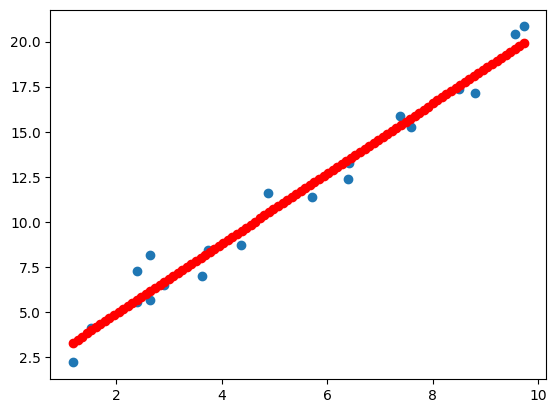

In [16]:
# @title Визуализация результата
plt.scatter(X, Y)
x = np.linspace(np.min(X), np.max(X), 100).reshape(1, -1)
y = x*theta[0] + theta_0
plt.scatter(x, y, color = 'red')